In [1]:
from itertools import product
import numpy as np
from scipy import stats
import pandas as pd
import pymc3 as pm
import theano.tensor as tt
import matplotlib.pyplot as plt

WDBC_PATH = "Datasets/WDBC.dat"

INFO_FEATURES  = ["id", "diagnosis"]
FEATURES_NAMES = ["radius", "texture", "perimeter", "area",
                  "smoothness", "compactness", "concavity",
                  "concave_points", "symmetry", "fractal_dimension"]
FEATURE_TYPES  = ["mean", "se", "worst"]  # mean, standard error, max or 'worst'
FEATURES       = ["_".join(p) for p in product(FEATURE_TYPES, FEATURES_NAMES)]

In [32]:
def load_wdbc_data(wdbc_path=WDBC_PATH):
    """ Load data and add headers. """
 
    names = INFO_FEATURES + FEATURES
    
    df = pd.read_csv(wdbc_path, header=0, names=names)
    df['id'] = df['id'].astype(str)  # treat ID as a string, to avoid multiple issues
    
    return df

wdbc = load_wdbc_data()
X = wdbc["mean_radius"]

Plot a histogram of the mean radius feature.

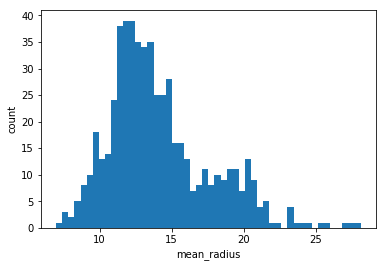

In [34]:
plt.hist(X, bins=50)
plt.xlabel("mean_radius")
_ = plt.ylabel("count")

## Radius distribution

We are asked to consider whether the radius feature is Normally distributed. For the purposes of this question, I will assume that we are interested in the "mean(radius)" feature, rather than the underlying radius in the hierarchical model sense.

We can reject the hypothesis that the data is Normally distributed straight away. The radius feature reported here is non-negative; the univariate Normal distribution, on the other hand, has support in $\mathbb{R}$. The feature distribution could perhaps be reasonably-well approximated by a Normal distribution but a better choice, in light of the apparent positive skewness in the data, would be the Gamma or LogNormal distribution. However, even a skewed distribution with semi-infinite support is probably not a good choice here. To me, it looks like the data can be better described by a mixture model. 

I will formulate my answer as a Bayesian model selection problem. I will use MCMC to compare three probabilistic models: Normal, Gamma, and a mixture of Normals.

### Mixture model with latent variables

Data $\{X_i\}$ in the mixture model is generated by a process that consists of $k$ Normal distributions:

$$ X_{i} \sim \mathcal{N} \left( f(\alpha_i), g(\alpha_i) \right) $$

Here, $f$ and $g$ are deterministic functions of a latent random variable $\alpha_i \in \{1, 2,\dots,k\}$, which determines which of the $k$ distributions a sample was generated by. We use

$$ \alpha_{i} \sim \text{Categorical}(\boldsymbol{p}) $$

where $\boldsymbol{p} = (p_1, p_2,\dots, p_k)$ is the random vector of probabilities that correspond to sample generation by the $i_{th}$ distribution. We can think of these as the weights of the $k$ components. We will use a Dirichlet prior for the mixtures, which is also the conjugate prior of the Categorical distribution:

$$ \boldsymbol{p} \sim \text{Dirichlet}(\boldsymbol{1}) $$

I used a vector of $1$s for the parameter of the Dirichlet to keep this prior uninformative.

We will infer the $\alpha_i$, as well as $\boldsymbol{p}$, in our simulations. 

The deterministic functions set the mean and standard deviation for each sample based on each $\alpha_i$:

$$ 
f(\alpha_i) = \begin{cases} 
      \mu_0, & \alpha_i = 0 \\
      \mu_1, & \alpha_i = 1 \\
      \dots
   \end{cases}
$$

$$ 
g(\alpha_i) = \begin{cases} 
      \sigma_0, & \alpha_i = 0 \\
      \sigma_1, & \alpha_i = 1 \\
      \dots
   \end{cases}
$$

We choose non-informative priors for the k Normal means:

$$
\mu_0, \mu_1, \dots, \mu_k \sim \mathcal{N}(\hat x, \hat\sigma(x))
$$

where the mean and standard deviation are estimated from the empirical sample. Similarly, for the k Normal standard deviations we choose:

$$
\sigma_0, \sigma_1, \dots \sigma_k \sim \text{Uniform}(0, 100)
$$

[Gelman 2006](https://projecteuclid.org/euclid.ba/1340371048) recommends using uniform or half-Cauchy priors for the variance parameter of a normal distribution, so we'll go with the simpler choice.

We will infer $\boldsymbol{\mu} = (\mu_1, \mu_2, \dots \mu_k)$ and $\boldsymbol{\sigma} = (\sigma_1, \sigma_2, \dots, \sigma_k)$, along with the $\alpha_i$ and $\boldsymbol{p}$, through our MCMC simulations.

Let's start with two clusters, since that is the most interesting case.

In [179]:
n_clusters = 2
n_data = X.shape[0]

mixture_model_2 = pm.Model()
with mixture_model_2:
    
    p = pm.Dirichlet('p', a=np.ones(n_clusters), shape=n_clusters)
    alpha = pm.Categorical("alpha", p=p, shape=n_data)
    
    # Define prior distributions for cluster parameters:
    
    # Use sample means and standard deviations.
    prior_means = np.array([np.mean(X)] * n_clusters)
    prior_std_devs = np.array([np.std(X)] * n_clusters)
    
    # The Normal means and standard deviations to infer.
    means = pm.Normal("means", mu=prior_means, sd=prior_std_devs, shape=n_clusters)
    std_devs = pm.Uniform("std_devs", 0, 10, shape=n_clusters)
    
    # The final generative process is Normal.
    obs_data = pm.Normal("observed", mu=means[alpha], sd=std_devs[alpha], observed=X)
    
with mixture_model_2:
    step_alpha = pm.ElemwiseCategorical(vars=[alpha], values=np.arange(n_clusters))
    step_parameters = pm.Metropolis(vars=[p, means, std_devs])
    mixture_trace_2 = pm.sample(50000, step=[step_alpha, step_parameters], chains=1)

/home/christos/Documents/Bay/env/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.
Sequential sampling (1 chains in 1 job)
CompoundStep
>ElemwiseCategorical: [alpha]
>CompoundStep
>>Metropolis: [std_devs]
>>Metropolis: [means]
>>Metropolis: [p]
100%|██████████| 50500/50500 [07:02<00:00, 119.63it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Check the chains for convergence.

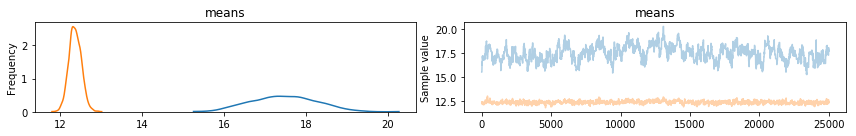

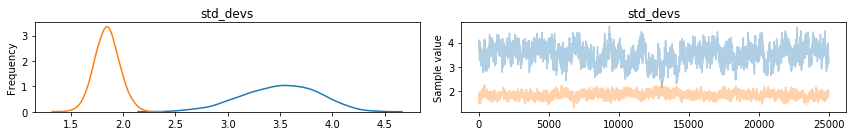

In [216]:
burnin=50000//2
pm.plots.traceplot(trace=mixture_trace_2[burnin:], varnames=["means"])
_ = pm.plots.traceplot(trace=mixture_trace_2[burnin:], varnames=["std_devs"])

Plot the posterior distributions.

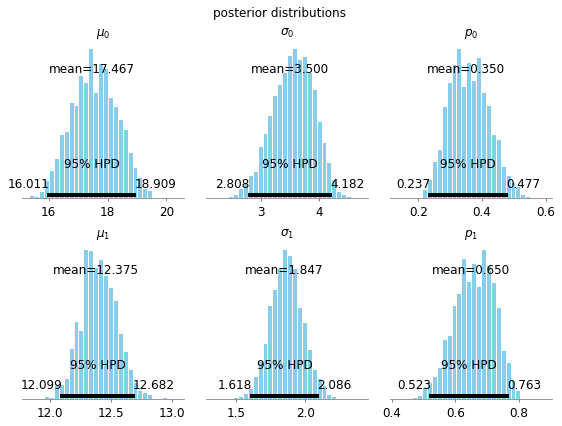

In [190]:
fig, ax = plt.subplots(2, 3, figsize=(8,6))

pm.plots.plot_posterior(trace=mixture_trace_2["means"][burnin:,0], ax=ax[0][0])
ax[0][0].set_title("$\mu_0$")

pm.plots.plot_posterior(trace=mixture_trace_2["means"][burnin:,1], ax=ax[1][0])
ax[1][0].set_title("$\mu_1$")

pm.plots.plot_posterior(trace=mixture_trace_2["std_devs"][burnin:,0], ax=ax[0][1])
ax[0][1].set_title("$\sigma_0$")

pm.plots.plot_posterior(trace=mixture_trace_2["std_devs"][burnin:,1], ax=ax[1][1])
ax[1][1].set_title("$\sigma_1$")

pm.plots.plot_posterior(trace=mixture_trace_2["p"][burnin:,0], ax=ax[0][2])
ax[0][2].set_title("$p_0$")

pm.plots.plot_posterior(trace=mixture_trace_2["p"][burnin:,1], ax=ax[1][2])
ax[1][2].set_title("$p_1$")

fig.suptitle("posterior distributions")
plt.tight_layout()
plt.subplots_adjust(top=0.9)

Get a sense of how well this model fits the data by overlaying two Normals using the mean of the posteriors.

In [217]:
mean_posterior_p = np.mean(mixture_trace_2["p"][burnin:], axis=0)
p = mean_posterior_p

mean_posterior_means = np.mean(mixture_trace_2["means"][burnin:], axis=0)
m = mean_posterior_means

mean_posterior_std_devs = np.mean(mixture_trace_2["std_devs"][burnin:], axis=0)
s = mean_posterior_std_devs

x_range = np.linspace(np.min(X) - np.std(X), np.max(X) + np.std(X), 100)

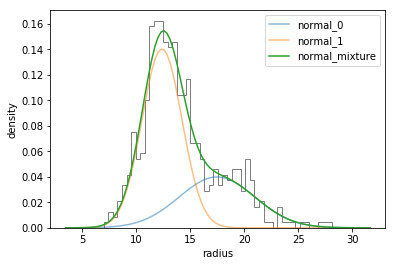

In [218]:
plt.hist(X, bins=50, histtype="step", color="k", alpha=0.5, density=True)
for i in range(2):
    plt.plot(x_range, p[i] * stats.norm.pdf(x_range, loc=m[i], scale=s[i]),
             alpha=0.5,
             label='normal_%d' % i)
    
plt.plot(x_range,
         p[0] * stats.norm.pdf(x_range, loc=m[0], scale=s[0]) +
         p[1] * stats.norm.pdf(x_range, loc=m[1], scale=s[1]),
         label='normal_mixture')
    
plt.legend()
plt.xlabel("radius")
_ = plt.ylabel("density")

Not bad, but it looks like the inferred parameters for the cluster on the right are impaired by the right-tail outliers in the sample. We can also see this from the sampling traces and posteriors of the standard deviation parameter, which itself has a large standard deviation. This suggests that Normal components might not be appropriate for this data.

### Gaussian model

In [117]:
normal_model = pm.Model()
with normal_model:
    
    # The Normal means and standard deviations to infer.
    mean = pm.Normal("mean", mu=np.mean(X), sd=np.std(X))
    std_dev = pm.Uniform("std_dev", 0, 10)
    
    # The final generative process is Normal.
    obs_data = pm.Normal("observed", mu=mean, sd=std_dev, observed=X)
    
with normal_model:
    step_parameters = pm.Metropolis(vars=[mean, std_dev])
    normal_trace = pm.sample(50000, step=[step_parameters], chains=1)

Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [std_dev]
>Metropolis: [mean]
100%|██████████| 50500/50500 [00:09<00:00, 5113.67it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Sampling chains:

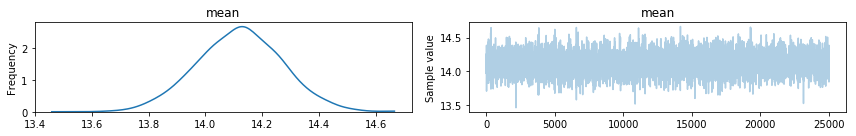

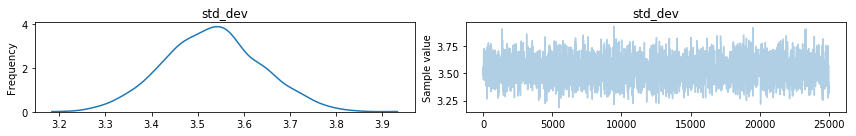

In [136]:
burnin=50000//2
pm.plots.traceplot(trace=normal_trace[burnin:], varnames=["mean"])
_ = pm.plots.traceplot(trace=normal_trace[burnin:], varnames=["std_dev"])

Posteriors:

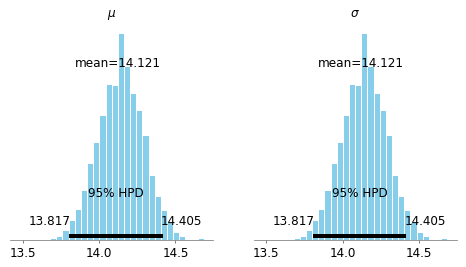

In [137]:
fig, ax = plt.subplots(1, 2, figsize=(8,4))
pm.plots.plot_posterior(trace=normal_trace["mean"][burnin:], ax=ax[0])
ax[0].set_title("$\mu$")
pm.plots.plot_posterior(trace=normal_trace["mean"][burnin:], ax=ax[1])
_ = ax[1].set_title("$\sigma$")

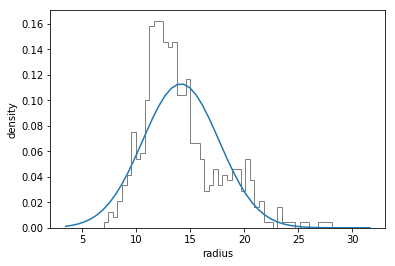

In [139]:
mean_posterior_mean = np.mean(normal_trace["mean"][burnin:], axis=0)
mean_posterior_std_dev = np.mean(normal_trace["std_dev"][burnin:], axis=0)
x_range = np.linspace(np.min(X) - np.std(X), np.max(X) + np.std(X))

plt.hist(X, bins=50, histtype="step", color="k", alpha=0.5, density=True)
plt.plot(x_range, stats.norm.pdf(x_range, loc=mean_posterior_mean,
                                          scale=mean_posterior_std_dev))
plt.xlabel("radius")
_ = plt.ylabel("density")

### Gamma model

The Gamma model follows.

In [155]:
gamma_model = pm.Model()
with gamma_model:
    
    # The Normal means and standard deviations to infer.
    mean = pm.Normal("mean", mu=np.mean(X), sd=np.std(X))
    std_dev = pm.Uniform("std_dev", 0, 10)
    
    # The final generative process is Normal.
    obs_data = pm.Gamma("observed", mu=mean, sd=std_dev, observed=X)
    
with gamma_model:
    step_parameters = pm.Metropolis(vars=[mean, std_dev])
    gamma_trace = pm.sample(50000, step=[step_parameters], chains=1)

Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [std_dev]
>Metropolis: [mean]
100%|██████████| 50500/50500 [00:10<00:00, 4679.17it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


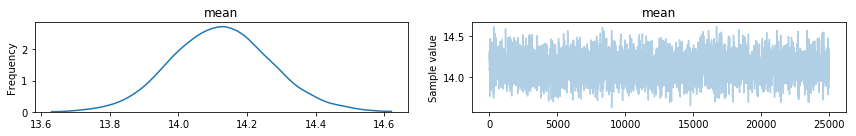

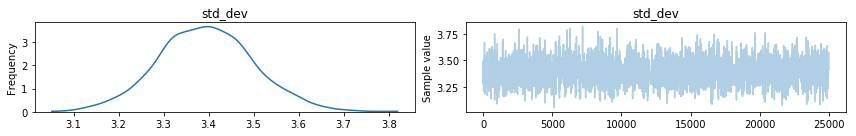

In [168]:
burnin=50000//2
pm.plots.traceplot(trace=gamma_trace[burnin:], varnames=["mean"])
_ = pm.plots.traceplot(trace=gamma_trace[burnin:], varnames=["std_dev"])

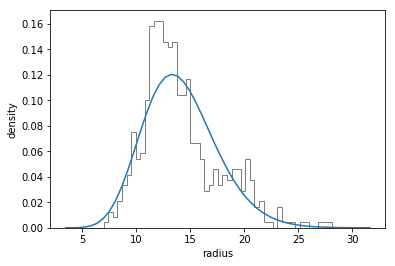

In [170]:
mean_posterior_mean = np.mean(gamma_trace["mean"][burnin:], axis=0)
m = mean_posterior_mean
mean_posterior_std_dev = np.mean(gamma_trace["std_dev"][burnin:], axis=0)
s = mean_posterior_std_dev
x_range = np.linspace(np.min(X) - np.std(X), np.max(X) + np.std(X))

plt.hist(X, bins=50, histtype="step", color="k", alpha=0.5, density=True)
plt.plot(x_range, stats.gamma.pdf(x_range, a=(m**2)/(s**2), scale=(s**2)/m))
plt.xlabel("radius")
_ = plt.ylabel("density")

Looks better than the Gaussian model.

### Model comparison and conslusions

 In comparing our probabilistic models, we need to keep in mind that the Gaussian mixture model can certainly overfit, so we want to be fully Bayesian and account for its larger number of fitting parameters. Ideally, we would like to calculate Bayes factors. Our sampling procedure, however, omits the marginal likelihood to only calculate proportional posteriors. Therefore, the posterior samples from our models are not immediately directly comparable.

The [Widely-applicable Information Criterion (WAIC)](http://www.jmlr.org/papers/volume14/watanabe13a/watanabe13a.pdf) is an approximation method for model comparison. Briefly, the WAIC is calculated from the computed log pointwise posterior predictive density, which is adjusted for the effective number of parameters to correct for overfitting.

[Note: you will see a fourth model in the exposition below. This is a mixture of two Gamma distributions that I simulated out of curiosity (see Appendix).]

In [243]:
normal_model.name = "normal"
gamma_model.name = "gamma"
mixture_model_2.name = "mixture_normal"
mixture_model_gamma_2.name = "mixture_gamma"

waic = pm.compare({normal_model: normal_trace, gamma_model: gamma_trace, 
                   mixture_model_2: mixture_trace_2,
                   mixture_model_gamma_2: mixture_gamma_trace_2}, ic='WAIC')

/home/christos/Documents/Bay/env/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


In [244]:
waic

,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
mixture_normal,2732.89,120.97,0,1,30.37,0,1
mixture_gamma,2772.85,135.02,39.95,0,31.63,8.87,1
gamma,2978.41,2.03,245.52,0,37.17,22.55,0
normal,3046.1,2.42,313.2,0,40.34,26.71,0


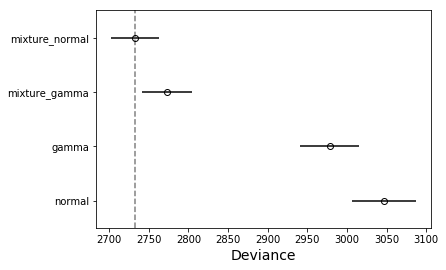

In [252]:
fig, ax = plt.subplots(1, 1)
pm.compareplot(waic, insample_dev=False, ax=ax, dse=False)

In the plot above, circles are mean WAIC scores and error bars are standard errors. The broken line shows score of the best-performing model. Lower WAIC scores are better.

The mixture models outperform the Normal and Gamma models (lowest WAIC scores), and the two mixture models perform similarly to each other. Of the two single-distribution models, the Gamma model fits our data better than the Normal. 

We can therefore draw the following conclusions:

1. We reject the hypothesis that the mean(radius) feature is Normally distributed -- even as an approximation -- in favor of the Gamma distribution. Remember that we can reject the Normal distribution off-hand because of its support in $\mathbb{R}$.
2. The data ought to be described as a mixture model of two distributions, be they Normal or Gamma, rather than any single distribution.

These conclusions are quantified and supported through the difference in model WAIC scores.

### Appendix: mixture model of Gamma distributions

I also wanted to see how a mixture model with Gamma, rather than Normal, distributions would perform. The parametrization is the same as that of the Normal mixture.

In [184]:
n_clusters = 2
n_data = X.shape[0]

mixture_model_gamma_2 = pm.Model()
with mixture_model_gamma_2:
    
    p = pm.Dirichlet('p', a=np.ones(n_clusters), shape=n_clusters)
    alpha = pm.Categorical("alpha", p=p, shape=n_data)
    
    # Define prior distributions for cluster parameters:
    
    # Use sample means and standard deviations.
    prior_means = np.array([np.mean(X)] * n_clusters)
    prior_std_devs = np.array([np.std(X)] * n_clusters)
    
    # The Normal means and standard deviations to infer.
    means = pm.Normal("means", mu=prior_means, sd=prior_std_devs, shape=n_clusters)
    std_devs = pm.Uniform("std_devs", 0, 10, shape=n_clusters)
    
    # The final generative process is Normal.
    obs_data = pm.Gamma("observed", mu=means[alpha], sd=std_devs[alpha], observed=X)
    
with mixture_model_gamma_2:
    step_alpha = pm.ElemwiseCategorical(vars=[alpha], values=np.arange(n_clusters))
    step_parameters = pm.Metropolis(vars=[p, means, std_devs])
    mixture_gamma_trace_2 = pm.sample(75000, step=[step_alpha, step_parameters], chains=1)

/home/christos/Documents/Bay/env/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.
Sequential sampling (1 chains in 1 job)
CompoundStep
>ElemwiseCategorical: [alpha]
>CompoundStep
>>Metropolis: [std_devs]
>>Metropolis: [means]
>>Metropolis: [p]
100%|██████████| 75500/75500 [10:47<00:00, 116.63it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


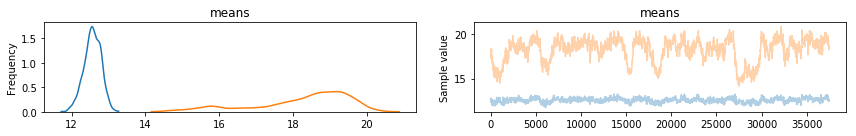

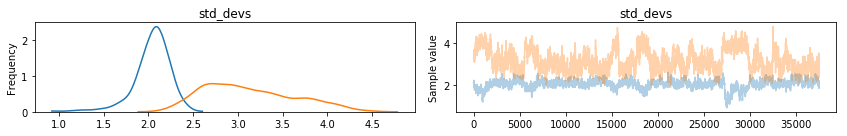

In [207]:
burnin=75000//2
pm.plots.traceplot(trace=mixture_gamma_trace_2[burnin:], varnames=["means"])
_ = pm.plots.traceplot(trace=mixture_gamma_trace_2[burnin:], varnames=["std_devs"])

These traces look pretty bad!

In [208]:
mean_posterior_p = np.mean(mixture_gamma_trace_2["p"][burnin:], axis=0)
p = mean_posterior_p

mean_posterior_means = np.mean(mixture_gamma_trace_2["means"][burnin:], axis=0)
m = mean_posterior_means

mean_posterior_std_devs = np.mean(mixture_gamma_trace_2["std_devs"][burnin:], axis=0)
s = mean_posterior_std_devs

x_range = np.linspace(np.min(X) - np.std(X), np.max(X) + np.std(X), 100)

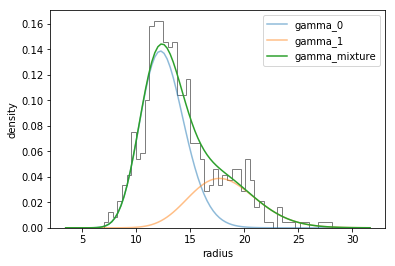

In [215]:
plt.hist(X, bins=50, histtype="step", color="k", alpha=0.5, density=True)
for i in range(2):
    plt.plot(x_range, 
             p[i] * stats.gamma.pdf(x_range, a=(m[i]**2)/(s[i]**2), scale=(s[i]**2)/m[i]),
             alpha=0.5,
             label='gamma_%d' % i)
    
plt.plot(x_range, p[0] * stats.gamma.pdf(x_range, a=(m[0]**2)/(s[0]**2), scale=(s[0]**2)/m[0]) +
                  p[1] * stats.gamma.pdf(x_range, a=(m[1]**2)/(s[1]**2), scale=(s[1]**2)/m[1]),
         label='gamma_mixture')
    
plt.legend()
plt.xlabel("radius")
_ = plt.ylabel("density")